In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

In [2]:
import rto

# Filtering and interpolation of axis

### generate some sample data

In [30]:
## generate some samples
nsamples = 20
samples_t = np.cumsum(np.random.uniform(11,500, nsamples).astype(int))
samples_x = 100 * np.random.random((nsamples))

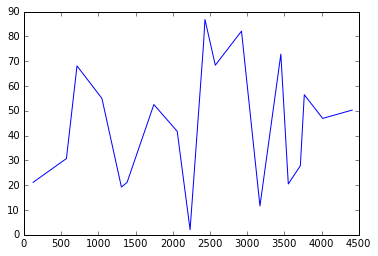

In [31]:
plt.plot(samples_t, samples_x)

In [32]:
samples_t

array([ 123,  571,  713, 1048, 1310, 1386, 1746, 2060, 2233, 2413, 2433,
       2572, 2924, 3172, 3453, 3553, 3715, 3768, 4015, 4412])

## filter with axisfilter

The input paramters are stepsize, order and window. In this example case, order doesn't  matter since we are plotting only the position. Stepsize tells the step for linear interpolation between last sample and current sample, window tells the number of sample taken to average over.

In [33]:
axisfilter_0 = rto.AxisFilter(10, 2, 10)
axisfilter_1 = rto.AxisFilter(10, 2, 100)

In [34]:
t, x = [],[]
axisfilter = axisfilter_0
for sample_t, sample_x in zip(samples_t, samples_x):
    axisfilter.new_sample(sample_t, sample_x)
    t = np.hstack((t, axisfilter.interpolator.time_steps))
    x = np.hstack((x, axisfilter.samples[:,0]))
t0, x0 = t.copy(), x.copy()
    
t, x = [],[]
axisfilter = axisfilter_1
for sample_t, sample_x in zip(samples_t, samples_x):
    axisfilter_1.new_sample(sample_t, sample_x)
    t = np.hstack((t, axisfilter.interpolator.time_steps))
    x = np.hstack((x, axisfilter.samples[:,0]))
t1, x1 = t.copy(), x.copy()


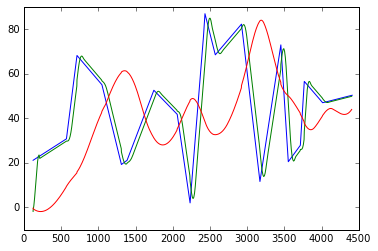

In [35]:
plt.plot(samples_t, samples_x, t0, x0, t1, x1)

# Using MotionExplorer

In [ ]:
import rto

In [ ]:
rto = reload(rto)

In [36]:
## generate some samples
nsamples = 100
samples_t = np.cumsum(np.random.uniform(11,100, nsamples).astype(int))
samples_x = 100 * np.random.random((nsamples))

In [37]:
mexp = rto.MotionExplorer(inputdim = 1)

In [38]:
t, x, d = [],[],[]
for sample_t, sample_x in zip(samples_t, samples_x):
    d_, _ = mexp.new_sample(sample_t, (sample_x, ))
    d = np.hstack((d, [d_]))
    t = np.hstack((t, mexp.axis[0].interpolator.time_steps))
    x = np.hstack((x, mexp.axis[0].samples[:,0]))

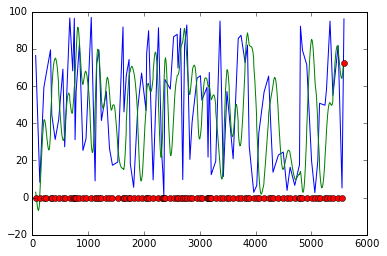

In [39]:
plt.plot(samples_t, samples_x, t, x, samples_t, d, 'o')

In [40]:
mexp.observations

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00],
       [  7.25150846e+01,   1.69280880e+00,  -3.28426089e-01,
         -1.37266821e-03]])

In [ ]:
mexp.